# Initial CNN model
****
Using the tensorflow tutorial by Magnus Pedersen on https://github.com/Hvass-Labs/TensorFlow-Tutorials we will build a very similar CNN, treating each spectrogram (converted earlier) as an image.

We will tune this model and then after try an RNN or combination thereof.

Another complication could be that our data is coming in as an array of positive and negative values. a CNN might prefer a [0,1] range

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
import pandas as pd
import matplotlib.image as img
import numpy as np
from sklearn.metrics import confusion_matrix
import time
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from datetime import timedelta
import math
import re
import os
from PIL import Image

In [2]:
tf.__version__

'1.10.0'

## Configuring the CNN
****
The original model used 16 filters. We will use the same. Those filters were 5x5, in order to maintain a similar proportion, we will use 13x13.

In [3]:
# Convolutional Layer 1.
filter_size1 = 7         # Convolution filters are 13x13 pixels.
num_filters1 = 56         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 7         # Convolution filters are 13x13 pixels.
num_filters2 = 112         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.
fc_size_2 = 256

## Loading Data

In [4]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [5]:
def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_") # for file types add '.+(type)'
    all_files = glob(os.path.join(data_dir, 'csv_full/train/*/*')) # for file types at (type)
                                                            # file path csv for 1sec exactly, and csv_full
                                                            # for all file

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_clips = fin.readlines()
        validation_files = [x[:-3] for x in validation_clips] # for file types at "+'(type)'" to [:-3]
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]
            label_vec = np.eye(len(id2name))[label_id]

            sample = (label, label_id, label_vec, uid, entry)
            if uid in valset:
                #if # only include val set that is precisely 1 sec
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'label_vec', 'user_id', 'file_name']
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    
    return train_df, valid_df

In [6]:
train_df, valid_df = load_data('')

There are 57923 train and 6798 val samples


In [7]:
imp_cols = ['label','label_vec','user_id','file_name']
train_df.head()

,label,label_id,label_vec,user_id,file_name
0,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3bfd30e6,csv_full/train/right/3bfd30e6_nohash_2
1,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",dabf67d9,csv_full/train/right/dabf67d9_nohash_0
2,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",b7a0754f,csv_full/train/right/b7a0754f_nohash_0
3,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",a1cff772,csv_full/train/right/a1cff772_nohash_2
4,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",28e47b1a,csv_full/train/right/28e47b1a_nohash_1


In [8]:
train_df['label_id'].value_counts()

11    36818
8      2134
0      2116
2      2115
9      2112
5      2111
6      2110
4      2106
1      2105
7      2101
3      2095
Name: label_id, dtype: int64

In [9]:
valid_df['label_id'].value_counts()

11    4221
1      270
3      264
0      261
2      260
9      260
6      257
7      256
5      256
4      247
8      246
Name: label_id, dtype: int64

In [10]:
avg_size = np.int(train_df[train_df['label_id'] != 11]['label_id'].value_counts().mean())
print(avg_size)

2110


The model has a tendancy to always predict 11, so we have to sample 11 down to the same amount as the other ones.

In [11]:
df_maj = train_df[train_df['label_id'] == 11]
df_rest = train_df[train_df['label_id'] != 11]

df_majority_downsampled = resample(df_maj, 
                                   replace=False,    # sample without replacement
                                   n_samples=avg_size,     # to match minority class
                                   random_state=5)

train_DS = pd.concat([df_majority_downsampled, df_rest])
train_DS.head()

,label,label_id,label_vec,user_id,file_name
38923,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1625acd8,csv_full/train/marvin/1625acd8_nohash_1
53094,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9aa5439d,csv_full/train/five/9aa5439d_nohash_2
19083,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",60472d26,csv_full/train/nine/60472d26_nohash_1
10120,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44dad20e,csv_full/train/happy/44dad20e_nohash_1
57029,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",937b433e,csv_full/train/four/937b433e_nohash_0


In [12]:
train_DS['label_id'].value_counts()

8     2134
0     2116
2     2115
9     2112
5     2111
11    2110
6     2110
4     2106
1     2105
7     2101
3     2095
Name: label_id, dtype: int64

In [13]:
columns_list = ['label_id', 'label', 'label_vec', 'user_id', 'file_name']

In [14]:
# The number of pixels in each dimension of an image.
img_height = 161
img_width = 99

# The images are stored in one-dimensional arrays of this length.
img_size_flat = img_height * img_width

# Tuple with height and width of images used to reshape arrays.
img_shape = (161,99)

# Number of classes, one class for each of 10 digits.
num_classes = 12

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

In [15]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [16]:
ran_images = train_DS.sample(9)#[train_df['label'] != 'unknown'].sample(9)
ran_images

,label,label_id,label_vec,user_id,file_name
55012,off,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8eb4a1bf,csv_full/train/off/8eb4a1bf_nohash_2
1449,right,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",e77d88fc,csv_full/train/right/e77d88fc_nohash_0
33243,unknown,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3402e488,csv_full/train/zero/3402e488_nohash_1
23243,stop,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",dc7ec25b,csv_full/train/stop/dc7ec25b_nohash_0
37683,up,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6cb6eee7,csv_full/train/up/6cb6eee7_nohash_0
48271,yes,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",493392c6,csv_full/train/yes/493392c6_nohash_0
47992,yes,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",e5e54cee,csv_full/train/yes/e5e54cee_nohash_1
23588,stop,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",c1d39ce8,csv_full/train/stop/c1d39ce8_nohash_1
21530,left,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",b21f0fa4,csv_full/train/left/b21f0fa4_nohash_0


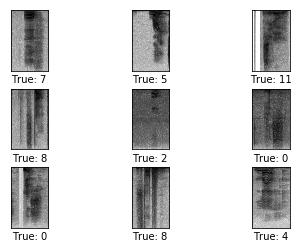

In [17]:
# Get the first images from the test-set.
#image_pics = [Image.open(x).convert('LA') for x in ran_images['file_name']]
#images = [np.genfromtxt(x,delimiter=',',dtype='float32') for x in ran_images['file_name']]
images = [pd.read_csv(x, sep=',',header=None).values for x in ran_images['file_name']]

# Get the true classes for those images.
cls_true = [y for y in ran_images['label_id']]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)
#np.array(image_pics[0].getdata())

In [18]:
#np.array([pd.read_csv(x, sep=',',header=None).T.values.tolist()[0] for x in valid_df['file_name']])[2:5, :]
#data.y_test[i:j, :]
#np.array([y for y in valid_df['label_vec']])[2:5, :]
len(valid_df)

6798

### Helper-functions for creating new variables
****
Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [19]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer
****
This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [20]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [21]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [22]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [23]:
#def new_dropout_layer(input, train = True):
#    layer = tf.layers.dropout(input, rate=0.5, noise_shape=None, seed=5, training=train)
#    return layer

## Placeholder variables
****
Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [24]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [25]:
x_image = tf.reshape(x, [-1, img_height, img_width, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [26]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

We will also need placeholders for the dropout layers

In [27]:
keep_prob_1 = tf.placeholder(tf.float32)#, name = 'drop_1')
keep_prob_2 = tf.placeholder(tf.float32)#, name = 'drop_2')

### Convolutional Layer 1

Create the first convolutional layer. It takes `x_image` as input and creates `num_filters1` different filters, each having width and height equal to `filter_size1`. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [28]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

In [29]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 81, 50, 56) dtype=float32>

### Convolutional Layer 2

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [30]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)

In [31]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 41, 25, 112) dtype=float32>

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [32]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [33]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 114800) dtype=float32>

In [34]:
num_features

114800

### Dropout Layer

To ensure we dont have any overfitting we will apply a dropout layer.

In [35]:
dropout_1 = tf.nn.dropout(layer_flat, keep_prob_1)#tf.placeholder(tf.float32, name = 'drop_1'))
dropout_1

<tf.Tensor 'dropout/mul:0' shape=(?, 114800) dtype=float32>

### Fully-Connected Layers

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

We will add a second fc layer of 256 neurons in the middle to improve accuracy.

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [36]:
layer_fc1 = new_fc_layer(input=dropout_1,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 256) dtype=float32>

In [37]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size_2,
                         use_relu=True)
layer_fc2

<tf.Tensor 'Relu_3:0' shape=(?, 256) dtype=float32>

In [38]:
#This dropout layer is causing problems with 
# You must feed a value for placeholder tensor 'drop_2' with dtype float
dropout_2 = tf.nn.dropout(layer_fc2, keep_prob_2)# tf.placeholder(tf.float32, name = 'drop_2'))
dropout_2

<tf.Tensor 'dropout_1/mul:0' shape=(?, 256) dtype=float32>

In [39]:
layer_fc3 = new_fc_layer(input=dropout_2,
                         num_inputs=fc_size_2,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc3

<tf.Tensor 'add_4:0' shape=(?, 12) dtype=float32>

### Predicted Class
****
The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [40]:
y_pred = tf.nn.softmax(layer_fc3) # This is where I should change for unknowns.
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

In [41]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Optimization Method

In [42]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [43]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run
****
### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.
****
The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [44]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Helper-functions

In [45]:
train_batch_size = 50

In [46]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        batch_df = train_DS.sample(train_batch_size)
        x_batch = np.array([pd.read_csv(x, sep=',',header=None).T.values.tolist()[0] for x in batch_df['file_name']])
        y_true_batch = np.array([y for y in batch_df['label_vec']])
        #x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob_1: 0.5, keep_prob_2: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [47]:
### This function is broken. the cls_true doesnt load properly.

def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array([pd.read_csv(x, sep=',',
                                   header=None).T.values.tolist()[0] for x in valid_df['file_name']])[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = np.array([y for y in valid_df['label_id']])[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [48]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = [y for y in valid_df['label_id']]
    #cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [49]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(valid_df)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0
    x_test_array = np.array([pd.read_csv(x, sep=',', 
                                         header=None).T.values.tolist()[0] for x in valid_df['file_name']])
    y_test_array = np.array([y for y in valid_df['label_vec']])
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = x_test_array[i:j, :]
        #data.x_test[i:j, :]
        
        # Get the associated labels.
        labels = y_test_array[i:j, :]
        #labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images, y_true: labels, keep_prob_1: 1, keep_prob_2: 1}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = [y for y in valid_df['label_id']]
    #cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Training the model

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [50]:
print_test_accuracy()

Accuracy on Test-Set: 3.5% (238 / 6798)


In [51]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  12.0%
Time usage: 0:00:05


In [52]:
print_test_accuracy()

Accuracy on Test-Set: 52.8% (3590 / 6798)


In [53]:
optimize(num_iterations=99)

Time usage: 0:05:55


Accuracy on Test-Set: 3.8% (258 / 6798)
Example errors:


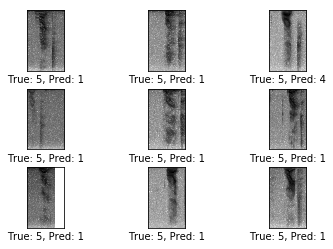

In [54]:
print_test_accuracy(show_example_errors=True)

In [55]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  22.0%
Optimization Iteration:    201, Training Accuracy:   8.0%
Optimization Iteration:    301, Training Accuracy:   8.0%
Optimization Iteration:    401, Training Accuracy:  12.0%
Optimization Iteration:    501, Training Accuracy:  22.0%
Optimization Iteration:    601, Training Accuracy:  34.0%
Optimization Iteration:    701, Training Accuracy:  44.0%
Optimization Iteration:    801, Training Accuracy:  30.0%
Optimization Iteration:    901, Training Accuracy:  36.0%
Time usage: 1:05:59


In [56]:
print_test_accuracy()#show_example_errors=True)

Accuracy on Test-Set: 24.1% (1639 / 6798)


In [57]:
optimize(num_iterations=5000)

Optimization Iteration:   1001, Training Accuracy:  48.0%
Optimization Iteration:   1101, Training Accuracy:  40.0%
Optimization Iteration:   1201, Training Accuracy:  58.0%
Optimization Iteration:   1301, Training Accuracy:  48.0%
Optimization Iteration:   1401, Training Accuracy:  54.0%
Optimization Iteration:   1501, Training Accuracy:  66.0%
Optimization Iteration:   1601, Training Accuracy:  48.0%
Optimization Iteration:   1701, Training Accuracy:  66.0%
Optimization Iteration:   1801, Training Accuracy:  64.0%
Optimization Iteration:   1901, Training Accuracy:  74.0%
Optimization Iteration:   2001, Training Accuracy:  68.0%
Optimization Iteration:   2101, Training Accuracy:  58.0%
Optimization Iteration:   2201, Training Accuracy:  74.0%
Optimization Iteration:   2301, Training Accuracy:  76.0%
Optimization Iteration:   2401, Training Accuracy:  76.0%
Optimization Iteration:   2501, Training Accuracy:  80.0%
Optimization Iteration:   2601, Training Accuracy:  70.0%
Optimization I

Accuracy on Test-Set: 72.0% (4897 / 6798)
Example errors:


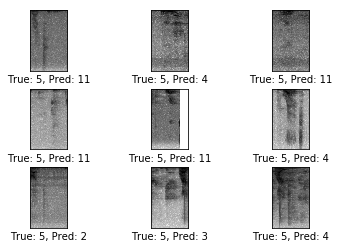

Confusion Matrix:
[[ 244    2    0    1    5    1    0    0    0    0    8]
 [   0  221    5    7    0    2    3    0    1   23    8]
 [   0    1  218    4    6    2    4    7    4   11    3]
 [   2   17    1  214    1    0    3    0    1   23    2]
 [   4    5    7    1  216    3    1    6    0    1    3]
 [   1    2    2    1   10  227    1    1    0    0   11]
 [   0    0    5    8    2    2  217    7    2    4   10]
 [   0    0   20    1    3    0    9  220    1    1    1]
 [   1    0   10    6    1    0    0    3  218    2    5]
 [   1   46    6   24    0    2    1    4    0  172    4]
 [  73  168   69  260   93  162  261  111   71  223 2730]]


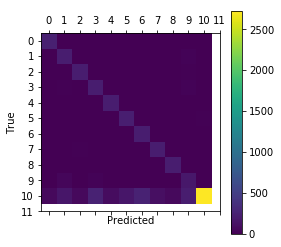

In [58]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [59]:
optimize(num_iterations=4000)

Optimization Iteration:   6001, Training Accuracy:  92.0%
Optimization Iteration:   6101, Training Accuracy:  94.0%
Optimization Iteration:   6201, Training Accuracy:  92.0%
Optimization Iteration:   6301, Training Accuracy:  92.0%
Optimization Iteration:   6401, Training Accuracy:  92.0%
Optimization Iteration:   6501, Training Accuracy:  96.0%
Optimization Iteration:   6601, Training Accuracy:  82.0%
Optimization Iteration:   6701, Training Accuracy:  94.0%
Optimization Iteration:   6801, Training Accuracy:  80.0%
Optimization Iteration:   6901, Training Accuracy:  94.0%
Optimization Iteration:   7001, Training Accuracy:  94.0%
Optimization Iteration:   7101, Training Accuracy:  96.0%
Optimization Iteration:   7201, Training Accuracy:  96.0%
Optimization Iteration:   7301, Training Accuracy:  90.0%
Optimization Iteration:   7401, Training Accuracy:  88.0%
Optimization Iteration:   7501, Training Accuracy:  92.0%
Optimization Iteration:   7601, Training Accuracy:  98.0%
Optimization I

Accuracy on Test-Set: 76.7% (5213 / 6798)
Example errors:


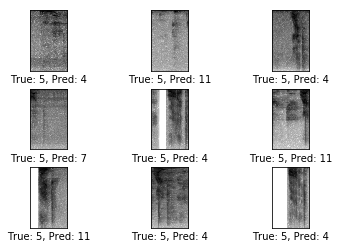

Confusion Matrix:
[[ 243    3    1    1    6    0    0    0    0    0    7]
 [   2  222    4    5    1    1    3    1    2   16   13]
 [   0    1  226    1    4    2    2   14    2    3    5]
 [   0   11    2  220    2    0    5    0    1   14    9]
 [   4    5    5    1  221    4    2    3    0    0    2]
 [   0    0    2    0   12  230    0    1    0    0   11]
 [   0    0    4    5    2    1  228    4    0    1   12]
 [   1    0   14    0    2    0    7  228    1    2    1]
 [   1    0   11    0    1    0    3    2  224    0    4]
 [   0   33    7   26    1    2    7    2    0  178    4]
 [  48  106   82  162   88  159  292   87   79  125 2993]]


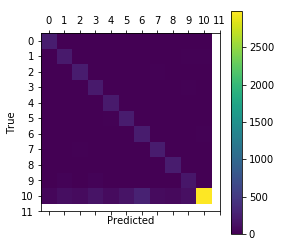

In [60]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [55]:
 session.close()

## Exporting the Model
****
Next we want to export the model to use it in another notebook to predict the test set